In [ ]:
from cmdstanpy import install_cmdstan
install_cmdstan()


CmdStan install directory: /root/.cmdstan
Installing CmdStan version: 2.38.0
Download successful, file: /tmp/tmpsy1vus1b
Extracting distribution
Unpacked download as cmdstan-2.38.0
Building version cmdstan-2.38.0, may take several minutes, depending on your system.
Installed cmdstan-2.38.0
Test model compilation


True

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from sklearn.preprocessing import StandardScaler
import os
import cmdstanpy
from cmdstanpy import CmdStanModel


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
BASE_DIR = "/content/drive/My Drive/project_BS"
DATA_CSV = os.path.join(BASE_DIR, "df_balanced.csv")

In [ ]:
df = pd.read_csv(DATA_CSV)

In [ ]:
stan_code = r"""
data {
  int<lower=1> N;                         // total observations
  int<lower=1> I;                         // number of donors
  int<lower=1> K;                         // number of target variables (K = 5)
  int<lower=1> P;                         // number of covariates

  array[N] int<lower=1, upper=I> id;      // donor index for each observation
  matrix[N, K] Y;                         // log target variables
  matrix[N, P] X;                         // covariate matrix

  real<lower=K> a_Sigma;
  real<lower=0> b_Sigma;

  real<lower=0> tau0;
}

parameters {
  // Regularized horseshoe for fixed effects
  matrix[P, K] beta_tilde;                // standardized coefficients
  vector<lower=0>[P] lambda;              // local shrinkage for each covariate
  real<lower=0> tau;                      // global shrinkage
  real<lower=0> c2_tilde;                 // slab parameter (unscaled)

  // donor-specific random effects (I x K)
  matrix[I, K] b;

  // hyperparameters for random effects
  row_vector[K] mu_b;
  cov_matrix[K] Sigma_b;

  // residual covariance across the K outcomes
  cov_matrix[K] Sigma;
}

transformed parameters {
  // actual fixed effects after applying regularized horseshoe
  matrix[P, K] beta;
  real<lower=0> c2;

  c2 = square(tau) * c2_tilde;  // slab variance

  for (p in 1:P) {
    real lambda_tilde =
      sqrt( (c2 * square(lambda[p])) /
            (c2 + square(tau) * square(lambda[p])) );
    for (k in 1:K) {
      beta[p, k] = beta_tilde[p, k] * lambda_tilde * tau;
    }
  }
}

model {
  // Regularized horseshoe for fixed effects
  to_vector(beta_tilde) ~ normal(0, 1);         // base Gaussian
  lambda ~ cauchy(0, 1);                        // local half-Cauchy (truncated >0)
  tau ~ cauchy(0, tau0);                        // global half-Cauchy, scale = tau0
  c2_tilde ~ inv_gamma(2, 8);                   // slab prior

  //  Prior for random effects
  mu_b ~ normal(0, 1);

  Sigma_b ~ inv_wishart(10,
                        0.5 * diag_matrix(rep_vector(1.0, K)));

  for (i in 1:I) {
    b[i] ~ multi_normal(mu_b, Sigma_b);
  }

  Sigma ~ inv_wishart(a_Sigma,
                      b_Sigma * diag_matrix(rep_vector(1.0, K)));

  // Likelihood
  for (n in 1:N) {
    row_vector[K] mu_n = X[n] * beta + b[id[n]];
    Y[n] ~ multi_normal(mu_n, Sigma);
  }
}

generated quantities {
  vector[N] log_lik;

  for (n in 1:N) {
    row_vector[K] mu_n = X[n] * beta + b[id[n]];
    log_lik[n] = multi_normal_lpdf(Y[n] | mu_n, Sigma);
  }
}

"""

stan_file = "Model_1.stan"
with open(stan_file, "w") as f:
    f.write(stan_code)

print("Stan model written to:", stan_file)

Stan model written to: Model_1.stan


In [ ]:
model = CmdStanModel(stan_file=stan_file)
ID_COL = "CAI"
ADD_INTERCEPT = False
target_list = ['PMAX', 'Glucosio', 'Trigliceridi', 'Colesterolo_Hdl', 'BMI']
covariate_cols = df.columns.drop(list(target_list) + [ID_COL])

cols_needed = [ID_COL] + target_list + list(covariate_cols)
df_model = df[cols_needed].dropna().copy()

Y_mat = df_model[target_list].to_numpy(dtype=float)
N, K = Y_mat.shape
X_mat = df_model[covariate_cols].to_numpy(dtype=float)
_, P = X_mat.shape

donor_ids, id_index = np.unique(df_model[ID_COL].to_numpy(), return_inverse=True)
I = len(donor_ids)
id_stan = id_index + 1

stan_data = {
    "N": int(N),
    "I": int(I),
    "K": int(K),
    "P": int(P),
    "Y": Y_mat,
    "X": X_mat,
    "id": id_stan,
    "a_Sigma": 10.0,
    "b_Sigma": 1.0,
    "tau0": 0.002

}

In [ ]:
fit = model.sample(
    data=stan_data,
    chains=4,
    parallel_chains=4,
    iter_warmup=500,
    iter_sampling=500,
    adapt_delta=0.9,
    max_treedepth=12,
    show_progress=True
)
print(fit.diagnose())

chain 1:   0%|          | 0/1000 [00:00<?, ?it/s, (Warmup)]

chain 2:   0%|          | 0/1000 [00:00<?, ?it/s, (Warmup)]

chain 3:   0%|          | 0/1000 [00:00<?, ?it/s, (Warmup)]

chain 4:   0%|          | 0/1000 [00:00<?, ?it/s, (Warmup)]

Exception: inv_wishart_lpdf: random variable is not symmetric. random variable[1,2] = -nan, but random variable[2,1] = -nan (in 'Model_1.stan', line 63, column 2 to line 64, column 63)
	Exception: inv_wishart_lpdf: random variable is not symmetric. random variable[1,2] = -nan, but random variable[2,1] = -nan (in 'Model_1.stan', line 63, column 2 to line 64, column 63)
	Exception: inv_wishart_lpdf: random variable is not symmetric. random variable[1,2] = -nan, but random variable[2,1] = -nan (in 'Model_1.stan', line 63, column 2 to line 64, column 63)
	Exception: inv_wishart_lpdf: random variable is not symmetric. random variable[1,5] = -nan, but random variable[5,1] = -nan (in 'Model_1.stan', line 63, column 2 to line 64, column 63)
	Exception: inv_wishart_lpdf: random variable is not symmetric. random variable[1,2] = -nan, but random variable[2,1] = -nan (in 'Model_1.stan', line 70, column 2 to line 71, column 65)
	Exception: inv_wishart_lpdf: random variable is not symmetric. random 


Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Rank-normalized split effective sample size satisfactory for all parameters.

Rank-normalized split R-hat values satisfactory for all parameters.

Processing complete, no problems detected.



In [ ]:
print(fit.diagnose())
summary_df = fit.summary()
summary_df.head(50)

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Rank-normalized split effective sample size satisfactory for all parameters.

Rank-normalized split R-hat values satisfactory for all parameters.

Processing complete, no problems detected.



,Mean,MCSE,StdDev,MAD,5%,50%,95%,ESS_bulk,ESS_tail,ESS_bulk/s,R_hat
lp__,10050.000000,0.648703,14.616300,14.872000,10025.400000,10050.300000,10073.400000,518.398,1106.060,0.162427,1.003320
"beta_tilde[1,1]",-0.254891,0.015908,0.639343,0.549212,-1.294990,-0.224388,0.769389,1626.480,1060.890,0.509616,1.007210
"beta_tilde[1,2]",0.680519,0.016629,0.705091,0.624753,-0.468267,0.672878,1.801960,1867.500,1060.460,0.585132,1.009360
"beta_tilde[1,3]",0.729110,0.022679,0.973658,0.958107,-0.877589,0.738821,2.294750,1864.540,1433.590,0.584205,1.001720
"beta_tilde[1,4]",0.430875,0.017865,0.751560,0.688851,-0.770122,0.403069,1.674350,1829.260,1240.500,0.573153,1.003340
"beta_tilde[1,5]",0.490642,0.015492,0.579980,0.452820,-0.367577,0.454270,1.461230,1526.590,674.659,0.478316,1.001980
"beta_tilde[2,1]",-0.130304,0.004016,0.121091,0.109620,-0.341615,-0.121486,0.053463,940.239,1223.070,0.294599,1.001470
"beta_tilde[2,2]",0.103007,0.004818,0.146138,0.137177,-0.122362,0.097108,0.350295,984.508,861.013,0.308470,1.006570
"beta_tilde[2,3]",2.821540,0.018532,0.620420,0.623326,1.842860,2.797390,3.871960,1178.920,1220.690,0.369385,1.005610
"beta_tilde[2,4]",0.680227,0.010764,0.260184,0.242662,0.322720,0.649695,1.181610,637.883,974.628,0.199864,1.004060


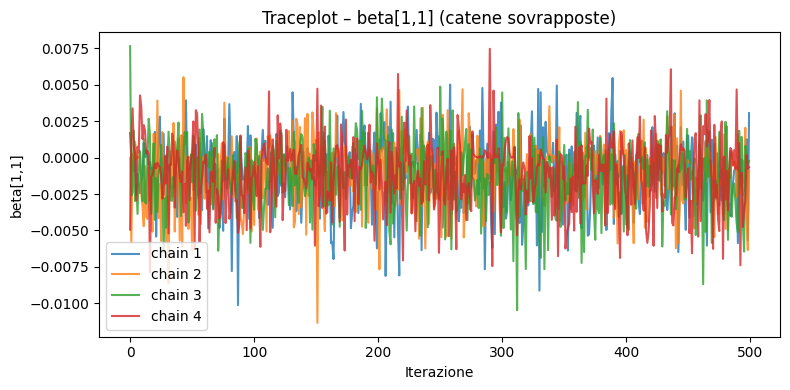

In [ ]:
# Interesting plots

beta = fit.stan_variable("beta")
tot_draws, P, K = beta.shape
chains = fit.chains # number of chains
iters = tot_draws // chains # number of draws per chain

beta_chains = beta.reshape(chains, iters, P, K)

fig, ax = plt.subplots(figsize=(8, 4))

for c in range(chains):
    ax.plot(beta_chains[c, :, 0, 0], label=f"chain {c+1}", alpha=0.8)

ax.set_xlabel("Iterazione")
ax.set_ylabel(f"beta[{0+1},{0+1}]")
ax.set_title(f"Traceplot – beta[{0+1},{0+1}] (catene sovrapposte)")
ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
with open("Model_1.pkl", "wb") as f:
    pickle.dump(fit, f)